In [1]:
import mesa
import networkx as nx
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def compute_variance(model):
    agent_opinions = [np.mean(agent.issue_positions) for agent in model.schedule.agents]
    return np.var(agent_opinions, axis=0)

def compute_confidence(agent):
    return np.var(agent.issue_positions, axis=0)

def compute_position(agent):
    return np.mean(agent.issue_positions)

In [5]:
class MastoAgent(mesa.Agent):
    """
    Mastodon agents can read timeline, post or retoot. 
    The issue positions is a distribution of opinions based on information an agent recieves and deems to be non-misinfo.
    The mean of issue positions is the overall opinion of the agent.
    The variance of issue positions is the confidence of the agent in its opinion. 

    TO IMPLEMENT
        # Unidirectional Following networks
        # Rules for following other agents
    """

    def __init__(self, vote, confidence, unique_id, model):
        super().__init__(unique_id, model)
        self.misinfo_sensitivity = np.clip(self.model.random.normal(self.model.misinfo_sensitivity, .05), 0, 1)
        self.issue_positions = np.clip(self.model.random.normal(vote, confidence, self.model.num_issues),
                                np.zeros(self.model.num_issues), np.ones(self.model.num_issues))
        self.homefeed = []
        self.n_misinfo = 0 # how much info has the agent regected thinking it was misinfo
        self.n_info = 0 # how much info has the agent used in issue updating (ie thinkging it's not misinfo)
        self.n_is_misinfo = 0 # how much info that the agent saw was actually misinfo 

    def generate_post(self):
        # post is generated based on issue positions and some random noise times confidence 
        post = np.zeros(2)
        post[0] = np.clip(np.mean(self.issue_positions) + (np.var(self.issue_positions) * self.model.random.normal(0,.5,1)), 0, 1)
        post[1] = 0
        return post
    
    def push_to_followers(self,post):
        # pushes a post to all the people who follow this agent
        followers = self.model.grid.get_cell_list_contents( self.model.grid.get_neighbors(self.pos) )
        for follower in followers:
            follower.homefeed.append(post)

    def check_misinfo(self,misinfo_cue):
        # True means this is misinfo and we need to reject it
        return (1 - misinfo_cue) <= np.clip(self.random.normal(self.misinfo_sensitivity, .25), 0,1) 

    def bayesian_update(self, true_timeline):
        weights = np.array([np.exp(self.model.misinfo_persuasion * misinfo_cue) for misinfo_cue in true_timeline[:,-1]])
        self.issue_positions = np.concatenate((self.issue_positions, np.mean(weights * true_timeline[:,:-1].T, axis = 1)),  axis=0)

    def updated_issue_positions(self, homefeed=False):
        feed = self.homefeed if homefeed else self.model.timeline
        
        if self.model.num_posts <= len(feed):
            timeline = np.array(feed[-self.model.num_posts:])
            
            # check and remove what is considered misinfo
            true_timeline = []
            for i in range(timeline.shape[0]):
                if not self.check_misinfo(timeline[i,-1]):
                    true_timeline.append(timeline[i])
                else:
                    self.n_misinfo += 1
                self.n_is_misinfo += 1 if timeline[i,-1] > 0 else 0
            
            if len(true_timeline) > 0:
                self.n_info += len(true_timeline)

                # update issue possitions 
                true_timeline = np.array(true_timeline, ndmin=2)
                self.bayesian_update(true_timeline)

                # retoot with p=.05 if similar opinion 
                for i in range(true_timeline.shape[0]):
                    if (np.linalg.norm(np.mean(self.issue_positions) - true_timeline[i, :-1])  < .2) and (self.model.random.random() < self.model.retoot_prob) :
                        self.model.timeline.append(true_timeline[i, :])
                        self.push_to_followers(true_timeline[i, :])
                
    def step(self):
        # 1. Generate a post and add it to the timeline with probability P1
        p = self.model.random.random()
        if p <= self.model.P1:
            # Generate post based on current issue opinions
            post = self.generate_post()
            # Add it to the "local" timeline
            self.model.timeline.append(post)
            # Add it to the homefeed of all the followers of this agent
            self.push_to_followers(post)
            
        # 2. Or look at the local timeline (same for everyone) with probability P2
        elif self.model.P1 < p <= self.model.P2:
            # Update issue positions
            # after updating, retoots based on similarity with probability retoot_prob (.05)
            self.updated_issue_positions()

        # 3. Else look at the home timeline (personalized)
        else:
            # Update issue positions
            # after updating, retoots based on similarity with probability retoot_prob (.05)
            self.updated_issue_positions(homefeed=True)
               


In [6]:
class MastoBot(mesa.Agent):
    """
   A general class for mastodon bots (ie agents that do not update their opinions and seek to inform others by posting information)
    """

    def __init__(self, issue_positions, p_misinfo, unique_id, model):
        super().__init__(unique_id, model)
        self.p_misinfo = p_misinfo
        self.issue_positions = issue_positions
            
    def generate_post(self):
        post = np.zeros(2)
        post[0] = np.mean(self.issue_positions) 
        post[1] = np.clip(self.model.random.normal(self.model.misinfo_mean,.2,1), 0, 1) if self.model.random.random() < self.p_misinfo else np.zeros(1)
        return post

    def step(self):
        post = self.generate_post()
        self.model.timeline.append(post)


In [7]:
class MastodonModel(mesa.Model):

    def __init__(self, N=400, ProB=50, AntiB=50, MisB=0, I=10, M = 5, S=.2, P1=.05, P2=1, MMean=.75, mu = 2, seed=None):

        self.num_agents = N # number of user/citizen agents
        self.pro_bots = ProB # number of bots with issue postion of 1 who do not use misinfo
        self.anti_bots = AntiB # number of bots with issue position of 0 who do not use misinfo
        self.misinfo_bots = MisB # number of bots with issue postion of 1 who use misinfo

        self.num_issues = I # number of positions in the original distribution of issue positions (set to one but can be increased to generalize across situations
        self.num_posts = M # number of posts users see in their timelines (both local and homefeed)
        self.citizens_pro = .5*self.num_agents # means 50% of agents are pro issue (1)

        self.P1 = P1 # probability of posting by a citizen agent
        self.P2 = P2 # probability of checking ones timeline 
        self.retoot_prob = .05
        self.misinfo_sensitivity = S # citizens sensitivity to misinformation (the mean of the normal with stdev .25 used in check_misinfo)
        self.timeline = [] # model-level variable for the "local" timeline (ie the timeline common to everyone)
        
        self.misinfo_mean = MMean # mean of misinformation cues (the mean of the normal with stdev .2 used in check_misinfo)
        self.misinfo_persuasion = mu

        ba = nx.barabasi_albert_graph(self.num_agents, 5, seed=None, initial_graph=None) 
        self.grid = mesa.space.NetworkGrid(ba)

        self.schedule = mesa.time.RandomActivation(self)
        self.random = np.random.default_rng(seed)
        self.running = True

        # Initializing all agents and bots 
        for i in range(self.num_agents):
            if i < self.citizens_pro:
                a = MastoAgent(1,.5, i, self)
            else:
                a = MastoAgent(0,.5, i, self)

            self.schedule.add(a)

            # Place agent on an empty node
            nodeid = self.random.integers(self.num_agents)
            while not self.grid.is_cell_empty(nodeid):
                nodeid = self.random.integers(self.num_agents)
            self.grid.place_agent(a, nodeid)

        for i in range(self.num_agents,self.num_agents + self.pro_bots):   
            b = MastoBot(np.ones(5), 0, i, self) #.75
            self.schedule.add(b)

        for i in range(self.num_agents + self.pro_bots, self.num_agents + self.pro_bots + self.anti_bots):   
            b = MastoBot(np.zeros(5), 0, i, self) #.25
            self.schedule.add(b)   

        for i in range(self.num_agents + self.pro_bots + self.anti_bots, self.num_agents + self.pro_bots + self.anti_bots + self.misinfo_bots):   
            b = MastoBot(np.ones(5), 1, i, self)
            self.schedule.add(b)      

        # Logging in the data 
        self.datacollector = mesa.DataCollector(
            model_reporters={
                            "variance": compute_variance
                            },
            agent_reporters={
                            "issue_positions": "issue_positions",
                            "position": compute_position,
                            "confs": compute_confidence,
                            "n_misinfo": "n_misinfo",
                            "n_info": "n_info",
                            "n_is_misinfo": "n_is_misinfo",
                            "type": type,
                            "misinfo_sensitivity":"misinfo_sensitivity"
                            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [8]:
# parameters to tune from real data:
# N - number of participants
# ProB - number pro bots / proportion pro content 
# AntiB - number anti bots / proportion anti content
# MisB - number of misinformation bots (also pro)
# S - sensitivity to misinfo used to check for misinfo : (1 - misinfo_cue) <= np.clip(self.random.normal(self.misinfo_sensitivity, .25), 0,1) 

# not sure how to set this 
# MMean - misinformation mean for generating misinfo cue: self.model.random.normal(self.model.misinfo_mean,.2,1)

n_iters = 1
params = {
        "N": 400, 
        "ProB": 45,
        "AntiB": 45, 
        "MisB": [0, 5, 10, 15, 20],
        "MMean": .75, #.5
        "S": [.05, .10, .15, .20, .25, .30, .35, .4, .45, .5], #.3
        "seed": 1, #[1, 2, 3, 4, 5], #345
        "P1": .05, #[.05, .1, .15, .2, .25],
        "P2": 1,
        "I": 10,
        "M": 5, 
        "mu": 1, #[0, .5, 1, 1.5, 2],
        }

results = mesa.batch_run(
    MastodonModel,
    parameters=params,
    iterations=n_iters,
    max_steps=40,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


In [9]:
MisB = [0, 5/95, 10/100, 15/105, 20/110]
S = [.05, .10, .15, .20, .25, .30, .35, .4, .45, .5]
results_df["vote"] = np.where(results_df.position > .5*np.ones(len(results_df)), 1, 0)
results_df["percent_misinfo"] = results_df.n_is_misinfo/(results_df.n_misinfo + results_df.n_info)
results_df["percent_rejected"] = results_df.n_misinfo/(results_df.n_misinfo + results_df.n_info)
results2 = results_df[(results_df.Step == 40) & (results_df.type == results_df.type[0])] 
aves = np.array(results2.groupby("RunId").vote.agg("mean"))
aves =aves.reshape(len(MisB), len(S),)
#aves =np.mean(aves.reshape(len(MisB), len(S), 5), axis = 2)

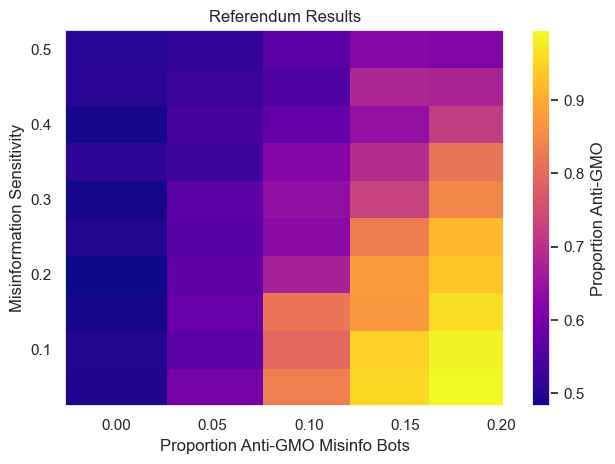

In [10]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh( MisB, S, aves.reshape(len(MisB),len(S)).T, \
                            cmap='plasma', vmin=np.min(aves), vmax=np.max(aves), shading='nearest')
fig.colorbar(pcm, ax=ax, label='Proportion Anti-GMO')
ax.set(title="Referendum Results", xlabel="Proportion Anti-GMO Misinfo Bots", ylabel="Misinformation Sensitivity")
plt.tight_layout()
plt.show()

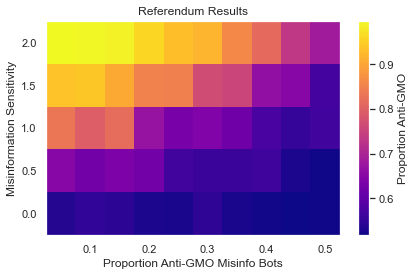

In [1707]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh( MisB, S, aves.reshape(len(MisB),len(S)).T, \
                            cmap='plasma', vmin=np.min(aves), vmax=np.max(aves), shading='nearest')
fig.colorbar(pcm, ax=ax, label='Proportion Anti-GMO')
ax.set(title="Referendum Results", xlabel="Proportion Anti-GMO Misinfo Bots", ylabel="Misinformation Sensitivity") # Not misinformaiton sensitivity but misinf cues
plt.tight_layout()
plt.show()

In [ ]:
MisB = [30, 35, 40, 45, 50]
S = [30, 35, 40, 45, 50]
results_df2["vote"] = np.where(results_df2.position > .5*np.ones(len(results_df2)), 1, 0)
results_df2["percent_misinfo"] = results_df2.n_is_misinfo/(results_df2.n_misinfo + results_df2.n_info)
results_df2["percent_rejected"] = results_df2.n_misinfo/(results_df2.n_misinfo + results_df2.n_info)
results2 = results_df2[(results_df2.Step == 40) & (results_df2.type == results_df2.type[0])] 
aves = np.array(results2.groupby("RunId").vote.agg("mean"))
aves = aves.reshape(len(MisB), len(S)) #np.mean(aves.reshape(len(MisB), len(S), 5), axis = 2)

In [ ]:
aves

In [ ]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh( MisB, S, aves.reshape(len(MisB), len(S)).T, \
                            cmap='plasma', vmin=np.min(aves), vmax=np.max(aves), shading='nearest')
fig.colorbar(pcm, ax=ax, label='Proportion Anti-GMO')
ax.set(title="Referendum Results", xlabel="Proportion Anti-GMO Misinfo Bots", ylabel="Misinformation Sensitivity")
plt.tight_layout()
plt.show()

In [19]:
results2

,RunId,iteration,Step,N,ProB,AntiB,MisB,MMean,S,seed,...,position,confs,n_misinfo,n_info,n_is_misinfo,type,misinfo_sensitivity,vote,percent_misinfo,percent_rejected
1024490,49,0,40,400,45,45,20,0.75,0.5,1,...,0.642163,0.067372,30.0,160.0,33.0,<class '__main__.MastoAgent'>,0.517279,1,0.173684,0.157895
1024491,49,0,40,400,45,45,20,0.75,0.5,1,...,0.624092,0.067066,23.0,167.0,23.0,<class '__main__.MastoAgent'>,0.463177,1,0.121053,0.121053
1024492,49,0,40,400,45,45,20,0.75,0.5,1,...,0.589426,0.075070,35.0,160.0,36.0,<class '__main__.MastoAgent'>,0.550336,1,0.184615,0.179487
1024493,49,0,40,400,45,45,20,0.75,0.5,1,...,0.570057,0.067191,24.0,171.0,23.0,<class '__main__.MastoAgent'>,0.533153,1,0.117949,0.123077
1024494,49,0,40,400,45,45,20,0.75,0.5,1,...,0.630527,0.051054,26.0,174.0,27.0,<class '__main__.MastoAgent'>,0.501779,1,0.135000,0.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024885,49,0,40,400,45,45,20,0.75,0.5,1,...,0.440966,0.098336,25.0,170.0,31.0,<class '__main__.MastoAgent'>,0.478059,0,0.158974,0.128205
1024886,49,0,40,400,45,45,20,0.75,0.5,1,...,0.464516,0.107462,25.0,160.0,32.0,<class '__main__.MastoAgent'>,0.433359,0,0.172973,0.135135
1024887,49,0,40,400,45,45,20,0.75,0.5,1,...,0.492752,0.069983,23.0,162.0,19.0,<class '__main__.MastoAgent'>,0.571848,0,0.102703,0.124324
1024888,49,0,40,400,45,45,20,0.75,0.5,1,...,0.461826,0.057844,14.0,176.0,17.0,<class '__main__.MastoAgent'>,0.390744,0,0.089474,0.073684


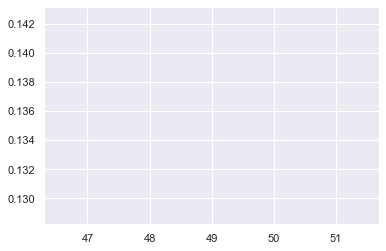

In [20]:
results2 = results_df[(results_df.S == .5) & (results_df.MisB == 20) & (results_df.Step == 40) & (results_df.type == results_df.type[0])] 
plt.plot(results2.groupby("RunId").percent_rejected.agg("mean"));

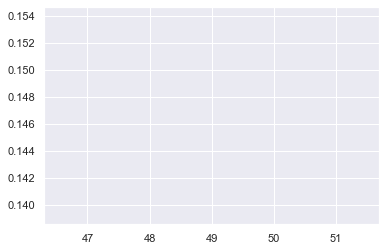

In [17]:
plt.plot(results2.groupby("RunId").percent_misinfo.agg("mean"));

In [30]:
results_df[(results_df.RunId == 25) & (results_df.AgentID == i)] 

,RunId,iteration,Step,N,ProB,AntiB,MisB,MMean,S,seed,...,position,confs,n_misinfo,n_info,n_is_misinfo,type,misinfo_sensitivity,vote,percent_misinfo,percent_rejected
506569,25,0,0,400,45,45,10,0.75,0.3,1,...,0.217029,0.090576,0.0,0.0,0.0,<class '__main__.MastoAgent'>,0.335504,0,NaN,NaN
507069,25,0,1,400,45,45,10,0.75,0.3,1,...,0.222078,0.082597,0.0,5.0,0.0,<class '__main__.MastoAgent'>,0.335504,0,0.000000,0.000000
507569,25,0,2,400,45,45,10,0.75,0.3,1,...,0.274015,0.105386,0.0,10.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.100000,0.000000
508069,25,0,3,400,45,45,10,0.75,0.3,1,...,0.299091,0.104825,0.0,15.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.066667,0.000000
508569,25,0,4,400,45,45,10,0.75,0.3,1,...,0.311369,0.099297,0.0,20.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.050000,0.000000
509069,25,0,5,400,45,45,10,0.75,0.3,1,...,0.311369,0.099297,0.0,20.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.050000,0.000000
509569,25,0,6,400,45,45,10,0.75,0.3,1,...,0.304570,0.093324,0.0,25.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.040000,0.000000
510069,25,0,7,400,45,45,10,0.75,0.3,1,...,0.312708,0.088485,0.0,30.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.033333,0.000000
510569,25,0,8,400,45,45,10,0.75,0.3,1,...,0.314511,0.083332,0.0,35.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.028571,0.000000
511069,25,0,9,400,45,45,10,0.75,0.3,1,...,0.309591,0.079114,0.0,40.0,1.0,<class '__main__.MastoAgent'>,0.335504,0,0.025000,0.000000


<AxesSubplot:xlabel='Time', ylabel='Opinion'>

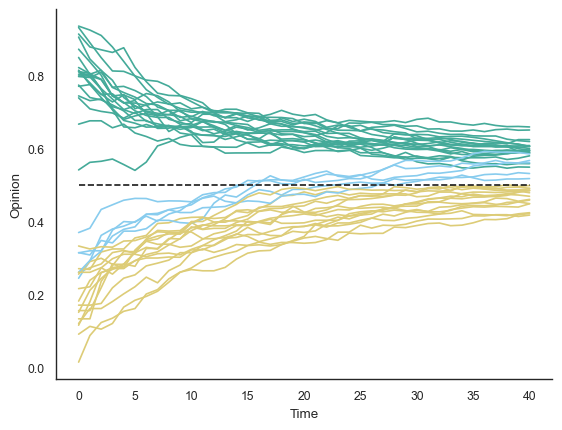

In [58]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='paper', style='white', font='sans-serif', font_scale=1, color_codes=True, rc=custom_params)
fig = plt.figure()
for i in range(180,220):
    results2 = results_df[(results_df.RunId == 25) & (results_df.AgentID == i)] 
    if np.mean(results2[results2.Step == 1].position) > .5 and np.mean(results2[results2.Step == max(results2.Step)].position) > .5:
        color = "#44AA99"
    elif np.mean(results2[results2.Step == 1].position) < .5 and np.mean(results2[results2.Step == max(results2.Step)].position) < .5:
        color = "#DDCC77"
    else:
        color="#88CCEE"
    plt.plot(results2.groupby("Step").position.agg("mean"), color=color);
a = pd.DataFrame({"Opinion":.5*np.ones(len(results2.Step)), "Time":results2.Step})
sns.lineplot(a.Time,a.Opinion,color="k",linestyle='dashed')


<AxesSubplot:xlabel='Step', ylabel='position'>

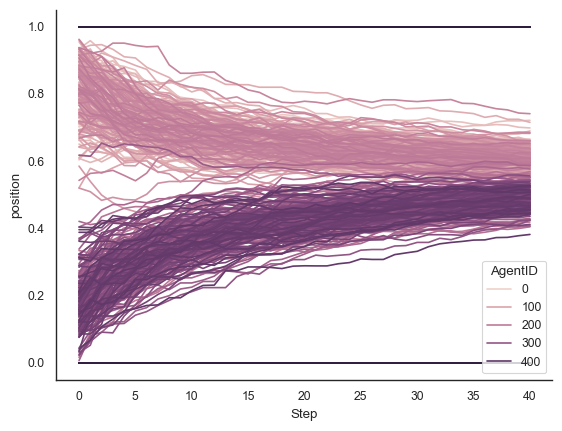

In [53]:
sns.lineplot(data=results_df[(results_df.RunId == 25)], x="Step", y="position", hue="AgentID")

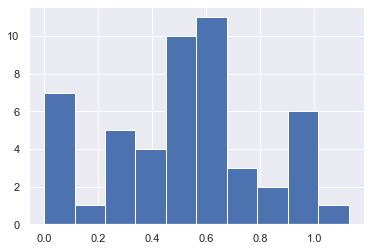

In [22]:
for i in range(219,220):
    results2 = results_df[(results_df.RunId == 49) & (results_df.Step == 40) & (results_df.AgentID == i)] 
    plt.hist(results2.issue_positions,color= "b");


In [ ]:
results2 = results_df[(results_df.RunId == 49) & (results_df.type == results_df.type[0])] 
plt.plot(results2.groupby("Step").position.agg("mean"));

In [ ]:
results2 = results_df[(results_df.RunId == 0) & (results_df.type == results_df.type[0])] 
plt.plot(results2.groupby("Step").position.agg("mean"));

In [ ]:
results2 = results_df[(results_df.RunId == 2) & (results_df.type == results_df.type[0])] 
plt.plot(results2.groupby("Step").position.agg("mean"));

In [ ]:
plt.plot(results2.groupby("Step").confs.agg("mean"));

In [ ]:
runid = 0
step = 1
results10 = results_df[(results_df.RunId == 0) & (results_df.Step == 0) & (results_df.type == results_df.type[0])] 
sns.histplot(results10.position.values, color="b")#, bins = 15) 
results10 = results_df[(results_df.RunId == 0) & (results_df.Step == 100) & (results_df.type == results_df.type[0])] 
sns.histplot(results10.position.values, color="r")#, bins = 15) 
plt.axis([0, 1, 0, 100]);

In [ ]:
runid = 0
step = 1
results10 = results_df[(results_df.RunId == runid) & (results_df.Step == 0) & (results_df.type == results_df.type[0])] 
sns.histplot(results10.confs.values, color="b")#, bins = 15) 
results10 = results_df[(results_df.RunId == 0) & (results_df.Step == 40) & (results_df.type == results_df.type[0])] 
sns.histplot(results10.confs.values, color="r")#, bins = 15) 
plt.axis([0, .25, 0, 100]);

In [ ]:
results10 = results_df[(results_df.RunId == 49) & (results_df.Step == 0) & (results_df.type == results_df.type[0])] 
values0 = np.where(results10.position > .5*np.ones(len(results10.position)), 1, 0)
results10 = results_df[(results_df.RunId == 49) & (results_df.Step == 40) & (results_df.type == results_df.type[0])] 
values1 = np.where(results10.position > .5*np.ones(len(results10.position)), 1, 0)

In [ ]:
sum(values0)

In [ ]:
sum(values1)

In [ ]:
sum(np.where((values1 - values0)  < np.zeros(len(values1)), 1,0))

In [ ]:
sum(np.where((values1 - values0)  > np.zeros(len(values1)), 1,0))

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(values1 , values0)

In [62]:
!pip install rsa

In [63]:
import rsa
publicKey, privateKey = rsa.newkeys(512)

In [64]:
print(publicKey)

PublicKey(8445635951885481946384941783152059389862424432508022925212061126741399308278812144314303141994516921242649719552119662077429453629765900267255917844906319, 65537)


In [65]:
print(privateKey)

PrivateKey(8445635951885481946384941783152059389862424432508022925212061126741399308278812144314303141994516921242649719552119662077429453629765900267255917844906319, 65537, 4228939215970733716107973351784762514880530390118303863676381249296515852972961457570765720190472518251874938463285821603739521726524316559095630263539201, 7441142255172995055681968505929294704094755031896588111190503383157505883479211967, 1134991868488224992937894025633243381690949916446112098584230460969132657)


In [76]:
message = "yarakyrychenko"
 
# rsa.encrypt method is used to encrypt
# string with public key string should be
# encode to byte string before encryption
# with encode method
encMessage = rsa.encrypt(message.encode(),
                         publicKey)
 
print("original string: ", message)
print("encrypted string: ", encMessage)
 
# the encrypted message can be decrypted
# with ras.decrypt method and private key
# decrypt method returns encoded byte string,
# use decode method to convert it to string
# public key cannot be used for decryption
decMessage = rsa.decrypt(encMessage, privateKey).decode()
 
print("decrypted string: ", decMessage)

original string:  yarakyrychenko
encrypted string:  b"\x00\xe6]\xde0a\xfa\xf77\xf4\x03J\xeb\x0f]`\xcc$S^\x981oB\xfc\x9d\xbc\xb9uB\x80\xef[e\xc4:5\xb6'A\x9fpw\xa44\x04]\xcc\x03y\x90\x91\x15\x9cN8\xdcJ\x97M\xd6\x95V2"
decrypted string:  yarakyrychenko


In [69]:
pkey = rsa.PublicKey(8445635951885481946384941783152059389862424432508022925212061126741399308278812144314303141994516921242649719552119662077429453629765900267255917844906319, 65537)

In [70]:
npkey = rsa.PrivateKey(8445635951885481946384941783152059389862424432508022925212061126741399308278812144314303141994516921242649719552119662077429453629765900267255917844906319, 65537, 4228939215970733716107973351784762514880530390118303863676381249296515852972961457570765720190472518251874938463285821603739521726524316559095630263539201, 7441142255172995055681968505929294704094755031896588111190503383157505883479211967, 1134991868488224992937894025633243381690949916446112098584230460969132657)

In [98]:
encMessage = rsa.encrypt(message.encode(),pkey)
 
print("original string: ", message)
print("encrypted string: ", encMessage)
 
# the encrypted message can be decrypted
# with ras.decrypt method and private key
# decrypt method returns encoded byte string,
# use decode method to convert it to string
# public key cannot be used for decryption
decMessage = rsa.decrypt(encMessage, npkey).decode()
 
print("decrypted string: ", decMessage)

original string:  yarakyrychenko
encrypted string:  b'\x05\x93\xc8\x95$j\xff\xa0\xbb*\xc6\xf0B\xa2c3\xe3ao2\xa7\xf8ch\x828\xeb\xe2\x9e5\xdcq%\xd2\x95]\xed0!\x94r\xa6\xec\xcc\x83h\xb2/\xa1\x93pD?\x80\xc2?\xc0&\x9b:G9\x8d\xaa'
decrypted string:  yarakyrychenko


In [116]:
type(encMessage)

bytes

In [125]:
encMessage.decode()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 1: invalid start byte

In [133]:
encMessage

b'\x05\x93\xc8\x95$j\xff\xa0\xbb*\xc6\xf0B\xa2c3\xe3ao2\xa7\xf8ch\x828\xeb\xe2\x9e5\xdcq%\xd2\x95]\xed0!\x94r\xa6\xec\xcc\x83h\xb2/\xa1\x93pD?\x80\xc2?\xc0&\x9b:G9\x8d\xaa'

In [140]:
str(encMessage)[2:-1].encode()

b'\\x05\\x93\\xc8\\x95$j\\xff\\xa0\\xbb*\\xc6\\xf0B\\xa2c3\\xe3ao2\\xa7\\xf8ch\\x828\\xeb\\xe2\\x9e5\\xdcq%\\xd2\\x95]\\xed0!\\x94r\\xa6\\xec\\xcc\\x83h\\xb2/\\xa1\\x93pD?\\x80\\xc2?\\xc0&\\x9b:G9\\x8d\\xaa'

In [143]:
encMessage.decode("utf-8") 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 1: invalid start byte

In [141]:
rsa.decrypt(str(encMessage)[2:-1].encode(), npkey).decode()

DecryptionError: Decryption failed

In [97]:
msg = rsa.BinData(0, 'CJ9sVqKLVmIIwiCyfrON7saDUG3nu7zvjXBBGE1d9FeJf+4b9UZi4cXcGoKNd4wu3qwMEdVLN2G6/3TVyIy5qA==')
decMessage = rsa.decrypt(msg, npkey).decode()

AttributeError: module 'rsa' has no attribute 'BinData'

In [ ]:
BinData(0, 'CJ9sVqKLVmIIwiCyfrON7saDUG3nu7zvjXBBGE1d9FeJf+4b9UZi4cXcGoKNd4wu3qwMEdVLN2G6/3TVyIy5qA==')


In [114]:
a = b'CJ9sVqKLVmIIwiCyfrON7saDUG3nu7zvjXBBGE1d9FeJf+4b9UZi4cXcGoKNd4wu3qwMEdVLN2G6/3TVyIy5qA=='
a.decode()

'CJ9sVqKLVmIIwiCyfrON7saDUG3nu7zvjXBBGE1d9FeJf+4b9UZi4cXcGoKNd4wu3qwMEdVLN2G6/3TVyIy5qA=='

In [112]:
decMessage = rsa.decrypt(a.encode(), npkey).decode()

DecryptionError: Decryption failed

In [ ]:
message = b"yarakyrychenko"

In [144]:
from cryptography.fernet import Fernet
 
# we will be encrypting the below string.
message = "hello geeks"
 
# generate a key for encryption and decryption
# You can use fernet to generate
# the key or use random key generator
# here I'm using fernet to generate key
 
key = Fernet.generate_key()
 
# Instance the Fernet class with the key
 
fernet = Fernet(key)
 
# then use the Fernet class instance
# to encrypt the string string must
# be encoded to byte string before encryption
encMessage = fernet.encrypt(message.encode())
 
print("original string: ", message)
print("encrypted string: ", encMessage)
 
# decrypt the encrypted string with the
# Fernet instance of the key,
# that was used for encrypting the string
# encoded byte string is returned by decrypt method,
# so decode it to string with decode methods
decMessage = fernet.decrypt(encMessage).decode()
 
print("decrypted string: ", decMessage)

original string:  hello geeks
encrypted string:  b'gAAAAABknEPylGqMIHREiPwLtTSJnwmHhfHq6Ljka1zHMkgKJMV7MFHq6RdpDucjY6PBXxjuh-m5f6011GxI4MJyXDFHoIK59g=='
decrypted string:  hello geeks


In [155]:
key

b'1N0TL2d-2WEOJcwUN3ukU70SExUSLQLXmjzUYkDaPyM='

In [ ]:
cryptography

In [157]:
new = "1N0TL2d-2WEOJcwUN3ukU70SExUSLQLXmjzUYkDaPyM=".encode()

In [158]:
fernet = Fernet(new)

In [159]:
encMessage = fernet.encrypt(message.encode())
 
print("original string: ", message)
print("encrypted string: ", encMessage)
 
# decrypt the encrypted string with the
# Fernet instance of the key,
# that was used for encrypting the string
# encoded byte string is returned by decrypt method,
# so decode it to string with decode methods
decMessage = fernet.decrypt(encMessage).decode()
 
print("decrypted string: ", decMessage)

original string:  hello geeks
encrypted string:  b'gAAAAABknEUmwW8eHHyM80jaq3WYGLoWBwUMDPbL-bx8Thk4C8yid077PdgwLW8oU3UTS8iUbRf9OMaIp_ijFmEBZ6TvLVaYvw=='
decrypted string:  hello geeks


In [182]:
message = "asheinin"
encMessage = fernet.encrypt(message.encode())
 
print("original string: ", message)
print("encrypted string: ", encMessage)
 
# decrypt the encrypted string with the
# Fernet instance of the key,
# that was used for encrypting the string
# encoded byte string is returned by decrypt method,
# so decode it to string with decode methods
decMessage = fernet.decrypt(encMessage).decode()
 
print("decrypted string: ", decMessage)

original string:  asheinin
encrypted string:  b'gAAAAABknEmqa18VmW04bV-3bbsTbzg-JtNavMA-cwjrzuQBL4sL_HpCXkjhyp4Ta4hNIj83_aVv-mq2p_9mY7DRRl-Ddnv8ig=='
decrypted string:  asheinin


In [188]:
encMessage.decode()

'gAAAAABknEmqa18VmW04bV-3bbsTbzg-JtNavMA-cwjrzuQBL4sL_HpCXkjhyp4Ta4hNIj83_aVv-mq2p_9mY7DRRl-Ddnv8ig=='

In [190]:
encMessage = 'gAAAAABknPULAqJZwp8Z1uaCrxjno9grhPOef_Ibp7jscYQyyoftYfDdEeC5cdhQBv8BiTV7RCPpHI8PCrfX1zfwOBi4okTCBA=='.encode()
decMessage = fernet.decrypt(encMessage).decode()
 
print("decrypted string: ", decMessage)

decrypted string:  n/a


In [166]:
newencmessage = 'gAAAAABknEfFKV_WQwznPLAYw0UBIRsRfYD8w0Q9fFeFqssz-fu2W8xmvWrnAtgXZ1Srl21nfTPDMakR1OTSUK1WRJkOddWQfA=='.encode()

In [167]:
fernet.decrypt(newencmessage).decode()

'kittycat'

In [148]:
str(b"gAAAAABknEPylGqMIHREiPwLtTSJnwmHhfHq6Ljka1zHMkgKJMV7MFHq6RdpDucjY6PBXxjuh-m5f6011GxI4MJyXDFHoIK59g==").encode()

b"b'gAAAAABknEPylGqMIHREiPwLtTSJnwmHhfHq6Ljka1zHMkgKJMV7MFHq6RdpDucjY6PBXxjuh-m5f6011GxI4MJyXDFHoIK59g=='"